# WeatherPy
----

#### Note
* Instructions have been included for each segment. You do not have to follow them exactly, but they are included to help you think through the steps.

In [42]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
from scipy.stats import linregress
from pprint import pprint
# Import API key
from api_keys import weather_api_key
from datetime import datetime

# Incorporated citipy to determine city based on latitude and longitude
from citipy import citipy

# Output File (CSV)
output_data_file = "output_data/cities.csv"

# Range of latitudes and longitudes
lat_range = (-90, 90)
lng_range = (-180, 180)

## Generate Cities List

In [43]:
# List for holding lat_lngs and cities
lat_lngs = []
cities = []

# Create a set of random lat and lng combinations
lats = np.random.uniform(lat_range[0], lat_range[1], size=1500)
lngs = np.random.uniform(lng_range[0], lng_range[1], size=1500)
lat_lngs = zip(lats, lngs)

# Identify nearest city for each lat, lng combination
for lat_lng in lat_lngs:
    city = citipy.nearest_city(lat_lng[0], lat_lng[1]).city_name
    
    # If the city is unique, then add it to a our cities list
    if city not in cities:
        cities.append(city)

# Print the city count to confirm sufficient count
print(len(cities))

612


### Perform API Calls
* Perform a weather check on each city using a series of successive API calls.
* Include a print log of each city as it's being processed (with the city number and city name).


In [44]:
city=[]
lat=[]
lng=[]
humidity=[]
clouds=[]
windspeed=[]
country=[]
date=[]
max_temp=[]
weather_dict ={"City": city,"Latitude":lat,"Longitude":lng,"Max Temperature (Celsius)": max_temp,"Humidity (%)":humidity,"Cloudiness (%)":clouds,"Wind Speed (mph)":windspeed,"Country": country,"Date":date}
j=1
print("Beginning Data Retrieval\n-----------------------------")
#Build query url
for i in range(len(cities)):
    url=f'https://api.openweathermap.org/data/2.5/weather?q={cities[i]}&appid={weather_api_key}'
    #get weather data
    weather_response = requests.get(url)
    weather_json=weather_response.json()
    try:
        city.append(weather_json['name'])
        lat.append(weather_json['coord']['lat'])
        lng.append(weather_json['coord']['lon'])
        max_temp.append(round(weather_json['main']['temp_max']-273.15,2))
        humidity.append(weather_json['main']['humidity'])
        clouds.append(weather_json['clouds']['all'])
        windspeed.append(weather_json['wind']['speed'])
        country.append(weather_json['sys']['country'])
        date.append(time.strftime('%D %H:%M', time.localtime(int(weather_json['dt']))))
        if i == j*50:
            j+=1
        print(f"Processing Record {i+1} of set {j} | {city[-1]}")
    except KeyError:
        if i == j*50:
            j+=1
        print("City not found. Skipping...")


Beginning Data Retrieval
-----------------------------
Processing Record 1 of set 1 | Nuuk
Processing Record 2 of set 1 | Besleney
City not found. Skipping...
Processing Record 4 of set 1 | Tasiilaq
Processing Record 5 of set 1 | Fallon
Processing Record 6 of set 1 | Gizo Government Station
Processing Record 7 of set 1 | Chui
Processing Record 8 of set 1 | Lüderitz
Processing Record 9 of set 1 | Bathsheba
City not found. Skipping...
Processing Record 11 of set 1 | Caravelas
Processing Record 12 of set 1 | Krasnosel'kup
Processing Record 13 of set 1 | Gamba
Processing Record 14 of set 1 | Qaanaaq
Processing Record 15 of set 1 | Misratah
Processing Record 16 of set 1 | Torbay
Processing Record 17 of set 1 | Leningradskiy
Processing Record 18 of set 1 | Chokurdakh
Processing Record 19 of set 1 | Florianópolis
Processing Record 20 of set 1 | Wajir
Processing Record 21 of set 1 | San Jose
Processing Record 22 of set 1 | Mataura
Processing Record 23 of set 1 | Bluff
Processing Record 24 of s

### Convert Raw Data to DataFrame
* Export the city data into a .csv.
* Display the DataFrame

In [45]:
raw_weather_df=pd.DataFrame(weather_dict)
raw_weather_df.to_csv("output_data/raw_city_data.csv",)
raw_weather_df

,City,Latitude,Longitude,Max Temperature (Celsius),Humidity (%),Cloudiness (%),Wind Speed (mph),Country,Date
0,Nuuk,64.1835,-51.7216,-14.00,72,20,7.20,GL,02/03/21 15:49
1,Besleney,44.2405,41.7387,7.73,57,98,2.96,RU,02/03/21 15:52
2,Tasiilaq,65.6145,-37.6368,-2.45,97,100,12.81,GL,02/03/21 15:52
3,Fallon,39.4735,-118.7774,8.00,34,75,7.72,US,02/03/21 15:52
4,Gizo Government Station,-8.1030,156.8419,28.03,79,95,7.84,SB,02/03/21 15:52
...,...,...,...,...,...,...,...,...,...
559,Bowen,-20.0167,148.2333,22.00,94,7,3.31,AU,02/03/21 15:54
560,Togur,58.3631,82.8265,-14.99,95,95,2.97,RU,02/03/21 15:51
561,São João da Barra,-21.6403,-41.0511,29.00,58,0,10.29,BR,02/03/21 15:50
562,Kosh-Agach,50.0000,88.6667,-15.42,87,100,0.64,RU,02/03/21 15:54


## Inspect the data and remove the cities where the humidity > 100%.
----
Skip this step if there are no cities that have humidity > 100%. 

In [46]:
#  Get the indices of cities that have humidity over 100%.
#high_humidity_cities_df
high_humidity_cities_indices=raw_weather_df.loc[raw_weather_df['Humidity (%)']>100].index
# Make a new DataFrame equal to the city data to drop all humidity outliers by index.
# Passing "inplace=False" will make a copy of the city_data DataFrame, which we call "clean_city_data".
clean_city_data=raw_weather_df.loc[raw_weather_df['Humidity (%)'] <= 100].reset_index()
clean_city_data.to_csv("output_data/clean_city_data.csv")
clean_city_data

,index,City,Latitude,Longitude,Max Temperature (Celsius),Humidity (%),Cloudiness (%),Wind Speed (mph),Country,Date
0,0,Nuuk,64.1835,-51.7216,-14.00,72,20,7.20,GL,02/03/21 15:49
1,1,Besleney,44.2405,41.7387,7.73,57,98,2.96,RU,02/03/21 15:52
2,2,Tasiilaq,65.6145,-37.6368,-2.45,97,100,12.81,GL,02/03/21 15:52
3,3,Fallon,39.4735,-118.7774,8.00,34,75,7.72,US,02/03/21 15:52
4,4,Gizo Government Station,-8.1030,156.8419,28.03,79,95,7.84,SB,02/03/21 15:52
...,...,...,...,...,...,...,...,...,...,...
559,559,Bowen,-20.0167,148.2333,22.00,94,7,3.31,AU,02/03/21 15:54
560,560,Togur,58.3631,82.8265,-14.99,95,95,2.97,RU,02/03/21 15:51
561,561,São João da Barra,-21.6403,-41.0511,29.00,58,0,10.29,BR,02/03/21 15:50
562,562,Kosh-Agach,50.0000,88.6667,-15.42,87,100,0.64,RU,02/03/21 15:54


## Plotting the Data
* Use proper labeling of the plots using plot titles (including date of analysis) and axes labels.
* Save the plotted figures as .pngs.

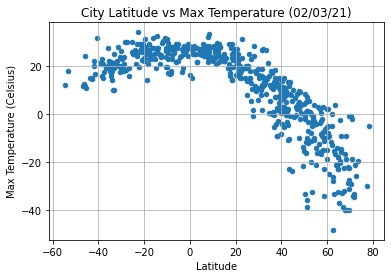

In [47]:
date= clean_city_data.Date.tolist()[0][0:8]
ax1 = clean_city_data.plot.scatter(x="Latitude", y="Max Temperature (Celsius)")
ax1.set_title(f"City Latitude vs Max Temperature ({date})")
ax1.grid(True)
plt.savefig(f"output_data/City_Latitude_vs_Max_Temperature_Scatter_Plot.png")
plt.show()

## Latitude vs. Humidity Plot

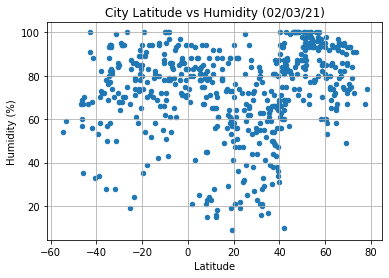

In [48]:
ax2 = clean_city_data.plot.scatter(x="Latitude", y="Humidity (%)")
ax2.set_title(f"City Latitude vs Humidity ({date})")
ax2.grid(True)
plt.savefig(f"output_data/City_Latitude_vs_Humidity_Scatter_Plot.png")
plt.show()

## Latitude vs. Cloudiness Plot

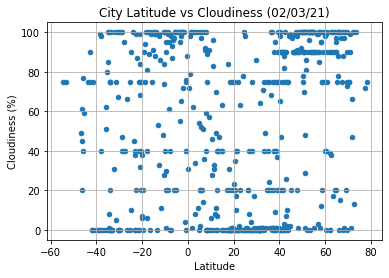

In [50]:
ax3 = clean_city_data.plot.scatter(x="Latitude", y="Cloudiness (%)")
ax3.set_title(f"City Latitude vs Cloudiness ({date})")
ax3.grid(True)
plt.savefig(f"output_data/City_Latitude_vs_Cloudiness_Scatter_Plot.png")
plt.show()

## Latitude vs. Wind Speed Plot

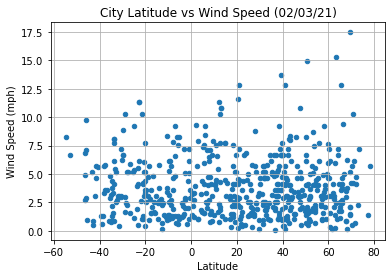

In [51]:
ax4 = clean_city_data.plot.scatter(x="Latitude", y="Wind Speed (mph)")
ax4.set_title(f"City Latitude vs Wind Speed ({date})")
ax4.grid(True)
plt.savefig(f"output_data/City_Latitude_vs_Wind_Speed_Scatter_Plot.png")
plt.show()

## Linear Regression

####  Northern Hemisphere - Max Temp vs. Latitude Linear Regression

####  Southern Hemisphere - Max Temp vs. Latitude Linear Regression

####  Northern Hemisphere - Humidity (%) vs. Latitude Linear Regression

####  Southern Hemisphere - Humidity (%) vs. Latitude Linear Regression

####  Northern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression

####  Southern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression

####  Northern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression

####  Southern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression